### Make all figures in the paper

In [1]:
# interactive figure
%matplotlib widget

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from matplotlib.patches import FancyArrow
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerTuple
from sys import platform
from viztool import FormatScalarFormatter
from spectrum import Gaussian_filter_2d
from calculate_KE_budgets import get_mld

In [3]:
def get_ah(h):
    mh = h.mean()
    ah = (h - mh)/mh
    return ah

def get_hoH(a):
    Q = np.cbrt((27*a**2 + np.sqrt(729*a**4 + 6912*a**3))/2)
    S = np.sqrt(2*a + a**2/4 + (Q-12*a/Q)/3)/2
    q = a/8*(a**2+12*a+24)
    p = -3/8*a**2 - 3*a
    x1 = -a/4 - S + np.sqrt(-4*S**2 - 2*p + q/S)/2
    return x1

In [4]:
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, '_get_coord_info_old'):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info
    Axis._get_coord_info = _get_coord_info_new

def plot_box_frame(ax, xmin, xmax, ymin, ymax, zmin, zmax, cloud=False, **edges_kw):
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    if not cloud:
        ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    else:
        ax.plot([xmin, xmin], [ymax, ymax], [zmin, zmax], **edges_kw)

# @wrap_matplotlib()
def plot_xyz3d(ax, ds, **kwargs):
    depth_lim = kwargs.pop('depth_lim')
    sub_str   = kwargs.pop('sub_str')
    blines    = kwargs.pop('blines')
    cloud     = kwargs.pop('cloud')
    var       = kwargs.pop('var', 'b')

    ustar = np.sqrt(ds.attrs['τ₀']/ds.attrs['ρ₀'])
    xvar, yvar, zvar = sorted(ds[var].dims)
    xb, yb, zb = sorted(ds.b.dims)

    top   = ds[varsel].sel({zvar: -depth_lim[0], zb: -depth_lim[0]}, method='nearest')
    south = ds[varsel].isel({yvar: 0, yb: 0}).sel({zvar: slice(-depth_lim[1],top[zvar]), zb: slice(-depth_lim[1],top[zb])})
    east  = ds[varsel].isel({xvar: -1, xb: -1}).sel({zvar: slice(-depth_lim[1],top[zvar]), zb: slice(-depth_lim[1],top[zb])})
    top['b']   = top.b   - ds.attrs['M²']*top[xb]
    south['b'] = south.b - ds.attrs['M²']*south[xb]
    east['b']  = east.b  - ds.attrs['M²']*east[xb]
    if var in ['u', 'v', 'w']:
        top[var]   = top[var]/ustar
        south[var] = south[var]/ustar
        east[var]  = east[var]/ustar

    xmin, xmax = np.around(south[xvar].min().data), np.around(south[xvar].max().data)
    ymin, ymax = np.around(east[yvar].min().data), np.around(east[yvar].max().data)
    zmin, zmax = np.around(east[zvar].min().data), np.around(top[zvar].data)
    Lx = xmax - xmin
    Ly = ymax - ymin
    Lz = zmax - zmin
    ry = 1.2 if Lx/Ly >= 2 else 1
    rz = 2.8 if Lz > 100 else 3.6
    zcloud = 52

    bkw = dict(levels=blines, linewidths=0.05, colors='xkcd:almost black')
    edges_kw = dict(color='xkcd:charcoal', linewidth=1, zorder=2)

    im = ax.contourf(top[xvar], top[yvar], top[var], zdir='z', offset=top[zvar], **kwargs)
    ax.contour(top[xb], top[yb], top.b, zdir='z', offset=top[zb], **bkw)
    if cloud:
        ax.contourf(ds.xC, ds.yC, ds.aheps, zdir='z', offset=zcloud, cmap='PRGn_r', extend='both',
                    vmin=-0.7, vmax=0.7, levels=np.arange(-0.7, 0.8, 0.1), zorder=2)

    bkw.update(linewidths=0.2, colors='xkcd:almost black') #in place
    X, Z = np.meshgrid(south[xvar], south[zvar])
    ax.contourf(X, south[var], Z, zdir='y', offset=south[yvar], **kwargs)
    X, Z = np.meshgrid(south[xb], south[zb])
    ax.contour(X, south.b, Z, zdir='y', offset=south[yb], **bkw)
    # ax.plot(ds.xC, np.ones_like(ds.xC)*south[yb].data, -ds.heps.isel(yC=0), lw=0.5, c='c')
    # ax.plot(ds.xC, np.ones_like(ds.xC)*south[yb].data, -ds.heps.mean('yC'), lw=0.5, c='c')

    Y, Z = np.meshgrid(east[yvar], east[zvar])
    ax.contourf(east[var], Y, Z, zdir='x', offset=east[xvar], **kwargs)
    Y, Z = np.meshgrid(east[yb], east[zb])
    ax.contour(east.b, Y, Z, zdir='x', offset=east[xb], **bkw)
    # ax.plot(np.ones_like(ds.yC)*east[xb].data, ds.yC, -ds.heps.isel(xC=-1), lw=0.5, c='c')
    # ax.plot(np.ones_like(ds.yC)*east[xb].data, ds.yC, -ds.heps.mean('xC'), lw=0.5, c='c')

    ax.axis('off')
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax],
           zlim=[zmin, zmax])
    plot_box_frame(ax, xmin, xmax, ymin, ymax, zmin, zmax, **edges_kw)
    if cloud:
        edges_kw.update(linestyle=':', linewidth=0.8, zorder=1)
        plot_box_frame(ax, xmin, xmax, ymin, ymax, zmax, zcloud, cloud=cloud, **edges_kw)

    ax.text2D(0.06, 0.36, sub_str, fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    ax.set_box_aspect((1, Ly/Lx*ry, Lz/Lx*rz))
    return im

In [5]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/campaign/univ/umcp0020/zhihuaz/wind-front-gsp/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

ds = []
dsf = []
cnames = ['s11_M036_Q000_W037_D270_St0',
          's11_M003_Q000_W444_D270_St0',
          's11_M009_Q000_W148_D000_St0',
          's11_M009_Q000_W148_D180_St0',
          's11_M009_Q000_W148_D090_St0',
          's11_M009_Q135_W148_D090_St0',
          's11_M009_Q000_W148_D270_St0',
         ]
for cname in cnames:
    tmp = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    # dVg    = tmp.attrs['M²']/tmp.f*tmp.bld
    # beta   = np.maximum(tmp.Qv/dVg**2, 0) + tmp.Qb*tmp.bld/dVg**3
    # alpha  = 14**3*beta**2
    # tmp['hoH'] = get_hoH(alpha)
    # tmp['hcvc'] = get_mld(tmp, cvar='wb')
    tmp.close()
    ds.append(tmp)

    itime_snapshot = -30
    tmpf = xr.open_dataset(data_dir+cname+'_full.nc').isel(time=itime_snapshot)
    tmpf.close()
    # tmpf = tmpf.where(((tmpf.time / np.timedelta64(int(tmpf.out_interval_slice), 's')) % 1) == 0, drop=True)
    # unique_time = ~pd.Index(tmpf.time).duplicated(keep='last')
    # idx_unique_time = np.arange(tmpf.time.size)[unique_time]
    # tmpf = tmpf.isel(time=idx_unique_time).isel(time=itime_snapshot)

    # tmpf['mld'] = get_mld(tmpf)
    # tmpf['dbdz'] = tmpf.b.differentiate('zC')
    # tmpf['hNsq'] = get_mld(tmpf, cvar='dbdz')
    # tmpf['amld'] = get_ah(tmpf.mld)
    # tmpf['ahNsq'] = get_ah(tmpf.hNsq)
    dsf.append(tmpf)

In [6]:
upfront_cnames = ['s11_M009_Q000_W148_D090_St0',
                  's11_M009_Q135_W148_D090_St0',
                  's11_M009_Q000_W444_D090_St0',
                  's11_M018_Q000_W148_D090_St0',
                  # 's11_M036_Q200_W037_D090_St0',
                  's11_M018_Q000_W444_D090_St0',
                  's11_M036_Q000_W444_D090_St0',
                  's11_M000_Q000_W148_D180_St0',
                  's11_M000_Q000_W444_D180_St0',
                 ]
uf = []
for cname in upfront_cnames:
    tmp = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    tmp.close()
    uf.append(tmp)

In [7]:
coarse_cnames = ['s22_M036_Q000_W037_D270_St0',
                 's22_M003_Q000_W444_D270_St0',
                 's22_M009_Q000_W148_D000_St0',
                 's22_M009_Q000_W148_D180_St0',
                 's22_M009_Q000_W148_D090_St0',
                 's22_M009_Q135_W148_D090_St0',
                 ]
dsc = []
for cname in coarse_cnames:
    tmp = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    tmp.close()
    dsc.append(tmp)

In [42]:
dsa = xr.open_dataset(data_dir+'/glade/derecho/scratch/zhihuaz/FrontalZone/Outputf11_M009_Q000_W148_D180_St0_averages.nc')
dsa.close()
dsa

<xarray.Dataset> Size: 103MB
Dimensions:  (zC: 256, zF: 257, xC: 512, yF: 128, xF: 512, yC: 128, time: 1571)
Coordinates:
  * zC       (zC) float64 2kB -125.8 -125.3 -124.8 ... -1.23 -0.7383 -0.2461
  * zF       (zF) float64 2kB -126.0 -125.5 -125.0 ... -0.9844 -0.4922 0.0
  * xC       (xC) float64 4kB -499.0 -497.1 -495.1 -493.2 ... 495.1 497.1 499.0
  * yF       (yF) float64 1kB 0.0 1.953 3.906 5.859 ... 242.2 244.1 246.1 248.0
  * xF       (xF) float64 4kB -500.0 -498.0 -496.1 -494.1 ... 494.1 496.1 498.0
  * yC       (yC) float64 1kB 0.9766 2.93 4.883 6.836 ... 245.1 247.1 249.0
  * time     (time) timedelta64[ns] 13kB 00:00:00 00:02:00 ... 2 days 04:20:00
Data variables: (12/41)
    vvsgs    (time, zC) float64 3MB ...
    TKE_eps  (time, zC) float64 3MB ...
    MKE_tur  (time, zC) float64 3MB ...
    CKE_tur  (time, zC) float64 3MB ...
    b        (time, zC) float64 3MB ...
    wut      (time, zC) float64 3MB ...
    ...       ...
    dvsdz    (zC) float64 2kB ...
    dusdz    (zC) float64 2kB ...
    Vbak     (zC) float64 2kB ...
    us       (zC) float64 2kB ...
    Bbak     (xC) float64 4kB ...
    vs       (zC) float64 2kB ...
Attributes: (12/76)
    save_checkpoint:          0
    Ly:                       250.0
    Tf:                       62831.85307179586
    use_Stokes:               0
    ∂v∂z_cgeo:                0
    time_averaging_stride:    1
    ...                       ...
    counter_geo_stress:       0
    Ny:                       128
    Oceananigans:             This file was generated using Oceananigans v0.9...
    start_from_restratified:  0
    RiB₁:                     1.2345679012345678
    σ_wind:                   0

In [35]:
nu = ds[0].wvsgs.isel(zF=slice(1,-1)).data / (-2*ds[0].v.diff('zC')/0.3125)
((ds[0].timeTf >= 2) & (ds[0].timeTf < 3)).sum()
nu[-210:,-1].mean()

(629, 319)

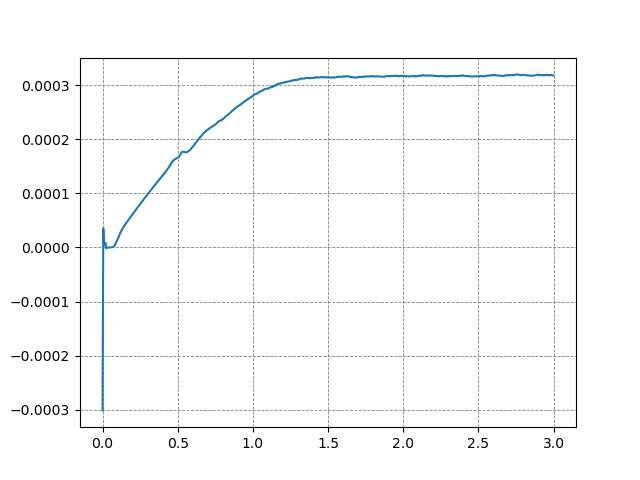

In [36]:
plt.close()
plt.figure()

plt.plot(ds[0].timeTf, nu[:,-1])
plt.grid(True, ls='--', c='gray', lw=0.6)

#### Investigate grid resolution sensitivity

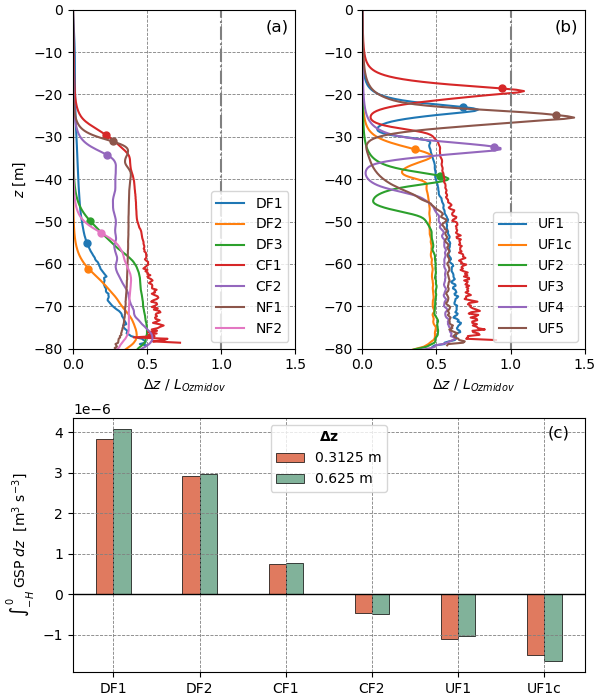

In [57]:
plt.close()
fig = plt.figure(figsize=(6,7), constrained_layout=True)
gs = fig.add_gridspec(7, 6)
time_interval = (ds[0].timeTf >= 2) & (ds[0].timeTf < 3)
cnames = ['DF1', 'DF2', 'CF1', 'CF2', 'UF1', 'UF1c']

ax0 = fig.add_subplot(gs[:4, :3])
for i in [0,1,6,2,3]:
    mLOz = ds[i].LOz.where(time_interval).mean('time')
    lLOz, = ax0.plot(0.3125/mLOz, ds[i].zC)
    mc= lLOz.get_color()
    H = ds[i].bld.where(time_interval).mean('time')
    ax0.plot(0.3125/mLOz.sel(zC=-H, method='nearest'), ds[i].zC.sel(zC=-H, method='nearest'),
              'o', c=mc, ms=5, label='_nolegend_')
for i in range(len(uf))[-2:]:
    mLOz = uf[i].LOz.where(time_interval).mean('time')
    lLOz, = ax0.plot(0.3125/mLOz, uf[i].zC)
    mc= lLOz.get_color()
    H = uf[i].bld.where(time_interval).mean('time')
    ax0.plot(0.3125/mLOz.sel(zC=-H, method='nearest'), uf[i].zC.sel(zC=-H, method='nearest'),
              'o', c=mc, ms=5, label='_nolegend_')

ax1 = fig.add_subplot(gs[:4, 3:], sharey=ax0)
for i in range(len(uf))[:-2]:
    mLOz = uf[i].LOz.where(time_interval).mean('time')
    lLOz, = ax1.plot(0.3125/mLOz, uf[i].zC)
    mc= lLOz.get_color()
    H = uf[i].bld.where(time_interval).mean('time')
    ax1.plot(0.3125/mLOz.sel(zC=-H, method='nearest'), uf[i].zC.sel(zC=-H, method='nearest'),
              'o', c=mc, ms=5, label='_nolegend_')

ax2 = fig.add_subplot(gs[4:, :])
iGSP, iGSPc = [], []
for i in range(len(ds))[:-1]:
    iGSP.append(ds[i].iGSP_ful.where(time_interval).mean('time'))
    iGSPc.append(dsc[i].iGSP_ful.where(time_interval).mean('time'))

barwd = 0.2
ax2.bar(np.arange(len(iGSP))-barwd/2, iGSP, width=barwd, color='#e07a5f', edgecolor='k', lw=0.5)
ax2.bar(np.arange(len(iGSPc))+barwd/2, iGSPc, width=barwd, color='#81b29a', edgecolor='k', lw=0.5)
ax2.axhline(0, c='k', lw=1, label='_nolegend_')
ax2.set_xticks(np.arange(len(iGSP)), cnames)

ax2.legend(['0.3125 m', '0.625 m'], title=r'$\bf{\Delta z}$', loc='upper center')
ax0.legend(['DF1', 'DF2', 'DF3', 'CF1', 'CF2', 'NF1', 'NF2'], loc='lower right',
             frameon=True, fontsize=10)
ax1.legend(['UF1', 'UF1c', 'UF2', 'UF3', 'UF4', 'UF5'], loc='lower right',
             frameon=True, fontsize=10)
ax0.axvline(1, ls='-.', c='gray')
ax1.axvline(1, ls='-.', c='gray')
ax0.grid(True, ls='--', c='gray', lw=0.6)
ax1.grid(True, ls='--', c='gray', lw=0.6)
ax2.grid(True, ls='--', c='gray', lw=0.6)
ax0.text(0.97, 0.97, '(a)', fontsize=12, ha='right', va='top', transform=ax0.transAxes)
ax1.text(0.97, 0.97, '(b)', fontsize=12, ha='right', va='top', transform=ax1.transAxes)
ax2.text(0.97, 0.97, '(c)', fontsize=12, ha='right', va='top', transform=ax2.transAxes)
ax0.set_xlim(0,1.5)
ax1.set_xlim(0,1.5)
ax0.set_ylim(-80,0)
ax0.set_xlabel(r'$\Delta z$ / $L_{Ozmidov}$')
ax1.set_xlabel(r'$\Delta z$ / $L_{Ozmidov}$')
ax0.set_ylabel('$z$ [m]')
ax2.set_ylabel(r'$\int_{-H}^0 \;\mathrm{GSP}\; dz$  [m$^3$ s$^{-3}$]');

plt.savefig('../Figures/FigA1', dpi=600);

In [13]:
HoLs = []
for i in range(len(uf)):
    HoLs.append(uf[i].bld.where(time_interval).mean('time').data*uf[i].attrs['M²']/uf[i].f/np.sqrt(uf[i].attrs['τ₀']/uf[i].attrs['ρ₀']))
print(HoLs)

[1.7325159997044668, 2.52131604211197, 1.7256456225059962, 9.921804598264556, 2.8105171504752624, 4.089878726274089]


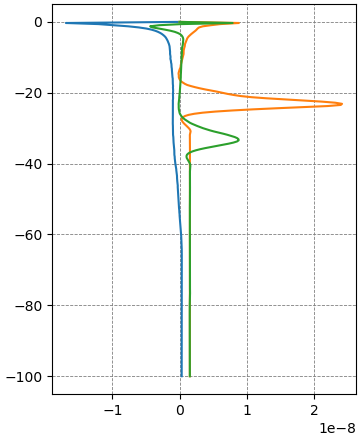

In [9]:
plt.close()
plt.figure(figsize=(3.6,4.4), constrained_layout=True)

time_interval = (ds[0].timeTf >= 2) & (ds[0].timeTf < 3)

i=0
plt.plot(ds[i].q.where(time_interval).mean('time'), ds[i].zF)

i=4
plt.plot(ds[i].q.where(time_interval).mean('time'), ds[i].zF)
i=5
plt.plot(ds[i].q.where(time_interval).mean('time'), ds[i].zF)
plt.grid(True, ls='--', c='gray', lw=0.6);

#### Investigate rolls in corss-front wind cases

In [240]:
dsr = []
cnames = ['s11_M009_Q000_W148_D000_St0',
          's11_M009_Q000_W148_D090_St0',
          's11_M009_Q000_W148_D180_St0',
          's11_M009_Q000_W148_D270_St0',
          's11_M000_Q000_W148_D180_St0',
          # 's11_M036_Q200_W037_D090_St0',
         ]
for cname in cnames:
    tmp = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    tmp.close()
    dsr.append(tmp)

In [152]:
def plot_nd_tke_budget(ax, ds, sub_str=None):
    kw = dict(lw=1.5)
    time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
    eps_scale = (ds.attrs['τ₀']/ds.attrs['ρ₀'])**(3/2) / ds.bld.where(time_interval).mean('time')

    l2, = ax.plot(ds.ASP_sc/eps_scale, ds.sC, **kw)
    l3, = ax.plot(ds.GSP_sc/eps_scale, ds.sC, 'C2', **kw)
    l4, = ax.plot(ds.wbt_sc/eps_scale, ds.sC, 'C1', **kw)
    l6, = ax.plot(-(ds.TKE_tur_sc + ds.TKE_prs_sc + ds.TKE_vis_sc)/eps_scale, ds.sC, 'xkcd:tan brown', lw=0.8)
    l7, = ax.plot(-ds.TKE_eps_sc/eps_scale, ds.sC, 'xkcd:cool grey', **kw)
    ax.text(0.02, 0.05, sub_str, fontsize=10, ha='left', va='bottom', transform=ax.transAxes)
    ax.grid('on', ls='--', lw=0.4)
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1.2,0)
    ax.set_ylabel('z / H')
    ax.set_xlabel(r'TKE budget terms / $(u^3_*/H)$')
    return [l2, l3, l4, l6, l7]

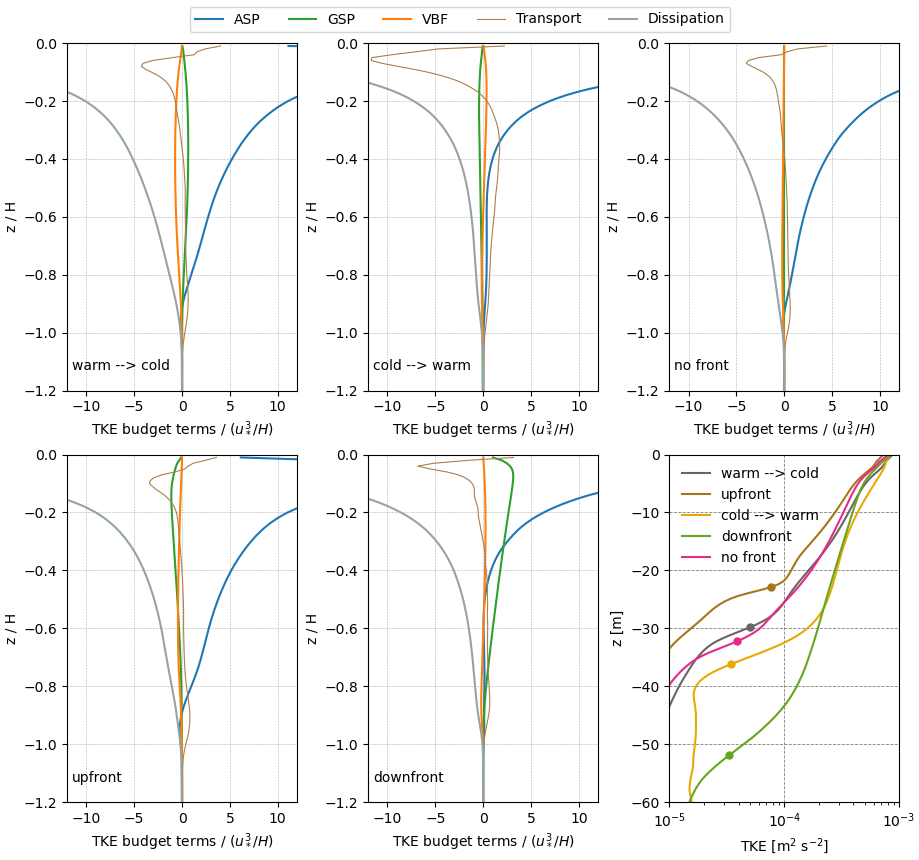

In [158]:
plt.close()
fig,ax = plt.subplots(2,3, figsize=(9.2,8.6), constrained_layout=True)
letters = ['warm --> cold', 'upfront', 'cold --> warm', 'downfront', 'no front']
time_interval = (dsr[0].timeTf >= 2) & (dsr[0].timeTf < 3)
from cycler import cycler
color_cycle = cycler(color=plt.get_cmap('Dark2_r').colors)

for i in range(len(dsr)):
    if i==-1:
        ix, iy = np.unravel_index(1, ax.shape, order='F')
    else:
        ix, iy = np.unravel_index(i, ax.shape, order='F')
    handles = plot_nd_tke_budget(ax[ix,iy], dsr[i], sub_str=f'{letters[i]}')


ax[1,2].set_prop_cycle(color_cycle)
for i in range(len(dsr)):
    mTKE = dsr[i].TKE.where(time_interval).mean('time')
    ltke, = ax[1,2].plot(mTKE, dsr[i].zC)
    H = dsr[i].bld.where(time_interval).mean('time')
    mc= ltke.get_color()
    ax[1,2].plot(mTKE.sel(zC=-H, method='nearest'), dsr[i].zC.sel(zC=-H, method='nearest'),
                 'o', c=mc, ms=5, label='_nolegend_')
plt.legend(letters, loc='upper left', frameon=False, fontsize=10)
plt.xscale('log')
plt.xlim(1e-5, 1e-3)
plt.ylim(-60, 0)
plt.grid(True, ls='--', c='gray', lw=0.6);
plt.xlabel('TKE [m$^2$ s$^{-2}$]')
plt.ylabel('z [m]');

fig.legend(handles, ['ASP', 'GSP', 'VBF', 'Transport', 'Dissipation'],
           loc='outside upper center', ncols=5);

#### 2D snaphost

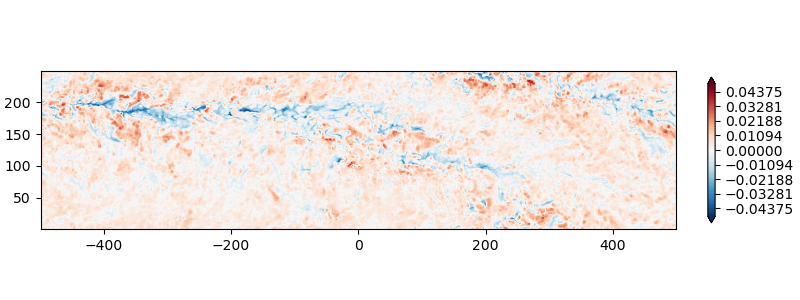

In [164]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
i = 3

plt.contourf(dsf[i].roll(yC=0).xC, dsf[i].roll(yC=0).yC, dsf[i].roll(yC=0).w.sel(zC=-15, method='nearest'),
             levels=np.linspace(-5e-2, 5e-2, 65), cmap='RdBu_r', vmin=-5e-2, vmax=5e-2, extend='both')
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal');

##### mixed layer depth MLD(x,y) from bulk buoyancy difference

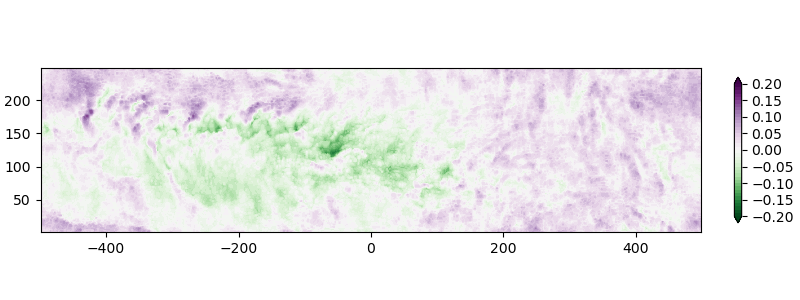

In [163]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
i = 3

plt.contourf(dsf[i].roll(yC=0).xC, dsf[i].roll(yC=0).yC, dsf[i].roll(yC=0).amld, cmap='PRGn_r',
             vmin=-0.2, vmax=0.2, levels=np.arange(-0.2, 0.21, 0.01), extend='both')
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal');

##### boundary layer depth $H$ from maximum vertical buoyancy gradient

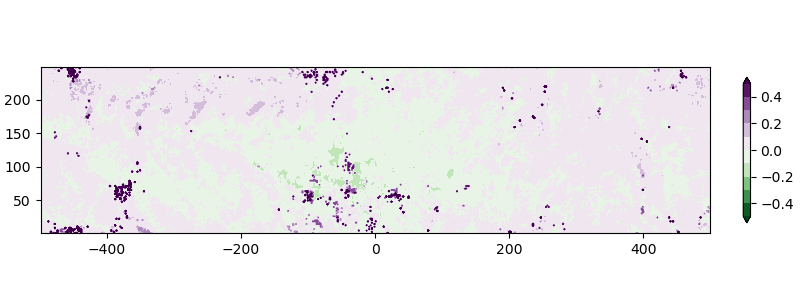

In [162]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
i = 3

# faheps = Gaussian_filter_2d(dsf[i].aheps, 30, 'xy')
plt.contourf(dsf[i].roll(yC=0).xC, dsf[i].roll(yC=0).yC, dsf[i].roll(yC=0).ahNsq, cmap='PRGn_r',
             vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.6, 0.1), extend='both')
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal');

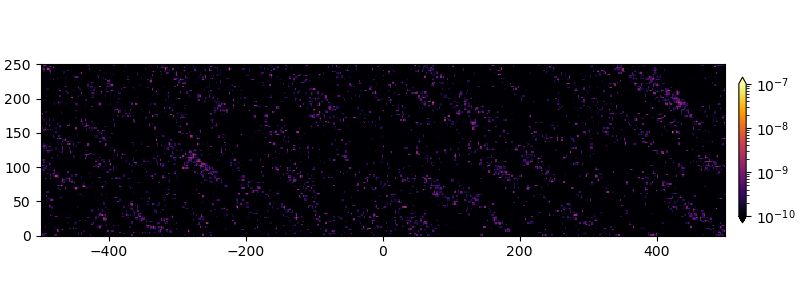

In [121]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
i = 4
pmkw = dict(cmap='inferno', norm=mcl.LogNorm(vmin=1e-10, vmax=1e-7))

pm = plt.pcolormesh(dsf[i].xC, dsf[i].yC, dsf[i].eps.sel(zC=-ds[i].bld[itime]-20, method='nearest').clip(min=1e-16), **pmkw)
cbar = plt.colorbar(pm, pad=0.02, shrink=0.5, extend='both', location='right')
plt.gca().set_aspect('equal');

#### 3D snaphost

##### along-front velocity $v$

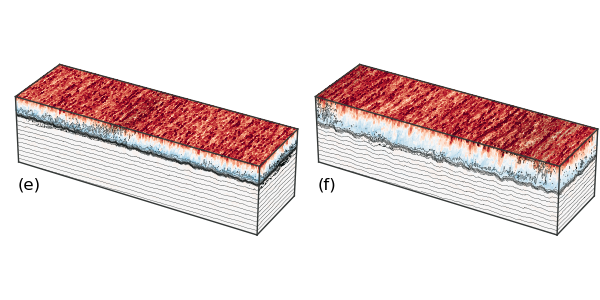

In [17]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'v'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -9, 9
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(-0.02, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both', cloud=False)

for i in range(len(dsf))[:-2]:
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_v{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    if ir!=2 and ic==1:
        [ax[k].cla() for k in range(ncol)];

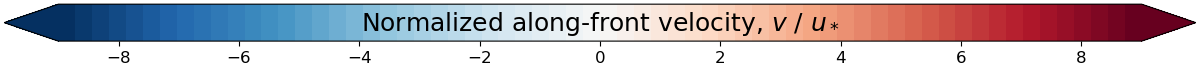

In [89]:
plt.close()
fig,ax = plt.subplots(1,1, figsize=(12,0.7), constrained_layout=True)

cmap0 = mpl.cm.RdBu_r.resampled(64)
norm0 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar0 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm0, cmap=cmap0), extend='both',
                    cax=ax, aspect=25, orientation='horizontal')
cbar0.set_label(r'Normalized along-front velocity, $v$ / $u_*$', labelpad=-40, fontsize=18)
cbar0.ax.tick_params(labelsize=12)

plt.savefig('../Figures/all_3Dsnapshot_v4', dpi=600);

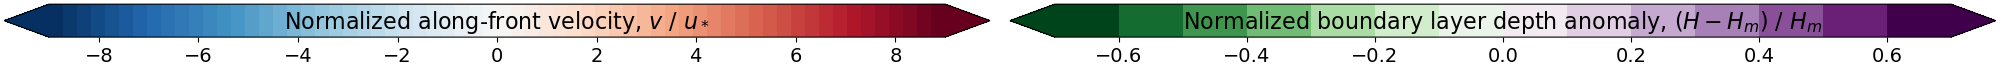

In [353]:
# plt.close()
# fig,ax = plt.subplots(1,2, figsize=(20,0.7), constrained_layout=True)

# cmap0 = mpl.cm.RdBu_r.resampled(64)
# norm0 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cbar0 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm0, cmap=cmap0), extend='both',
#                     cax=ax[0], aspect=20, orientation='horizontal')
# cbar0.set_label(r'Normalized along-front velocity, $v$ / $u_*$', labelpad=-41, fontsize=16)
# cbar0.ax.tick_params(labelsize=14)

# cmap1 = mpl.cm.PRGn_r.resampled(14)
# norm1 = mpl.colors.Normalize(vmin=-0.7, vmax=0.7)
# cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1), extend='both',
#                     cax=ax[1], aspect=20, orientation='horizontal')
# cbar1.set_label(r'Normalized boundary layer depth anomaly, $(H-H_m)$ / $H_m$', labelpad=-41, fontsize=16)
# cbar1.ax.tick_params(labelsize=14);

# plt.savefig('../Figures/all_3Dsnapshot_v4', dpi=600);

##### cross-front velocity $u$

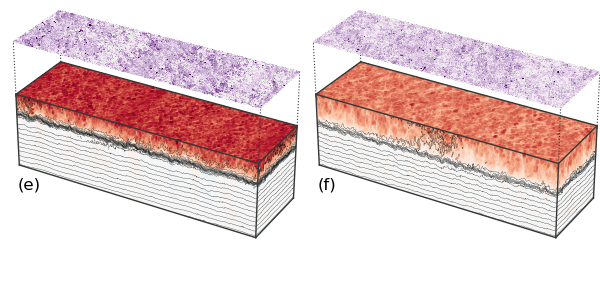

In [364]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'u'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -12, 12
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(-0.02, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

for i in range(len(dsf))[-2:]:
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    # if ir!=2 and ic==1:
    #     [ax[k].cla() for k in range(ncol)];

##### vertical velocity $w$

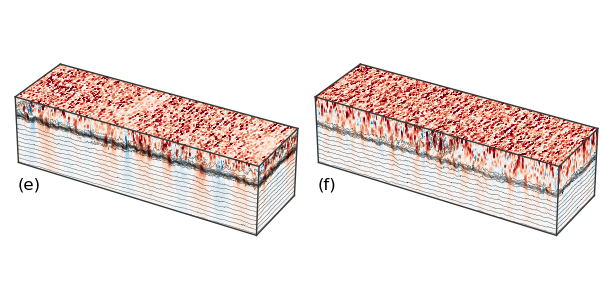

In [19]:
plt.close()
nrow, ncol = 1, 2
subplot_kw = dict(projection='3d', computed_zorder=False)
fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

var = 'w'
varsel = [var, 'b']
letter = 'abcdef'
vmin, vmax = -2, 2
depth_lim = [3, 80]
plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(-0.02, 2.6, 0.008)*1e-2,
                  levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

for i in range(len(dsf)):
    plt_kwargs.update(sub_str=f'({letter[i]})')
    ir, ic = np.unravel_index(i, (3,2))
    im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
    if ic==1:
        plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
    if ir!=2 and ic==1:
        [ax[k].cla() for k in range(ncol)];

##### potential vorticity $q$

In [ ]:
# plt.close()
# nrow, ncol = 1, 2
# subplot_kw = dict(projection='3d', computed_zorder=False)
# fig, ax = plt.subplots(nrow, ncol, figsize=(6,3), subplot_kw=subplot_kw)
# plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, right=1, left=0)

# var = 'q'
# varsel = [var, 'b']
# letter = 'abcdef'
# vmin, vmax = -3e-10, 3e-10
# depth_lim = [3, 80]
# plt_kwargs = dict(var=var, cmap='RdBu_r', vmin=vmin, vmax=vmax, blines=np.arange(0, 2.6, 0.008)*1e-2,
#                   levels=np.linspace(vmin, vmax, 64), depth_lim=depth_lim, extend='both')

# for i in range(len(dsf))[:2]:
#     plt_kwargs.update(sub_str=f'({letter[i]})')
#     ir, ic = np.unravel_index(i, (3,2))
#     im = plot_xyz3d(ax[ic], dsf[i], **plt_kwargs);
#     if ic==1:
#         plt.savefig(f'../Figures/all_3Dsnapshot_{var}{ir+1}', dpi=600, bbox_inches='tight', pad_inches=0);
#     # if ir!=2 and ic==1:
#     #     [ax[k].cla() for k in range(ncol)];

#### Surface velocity evolution

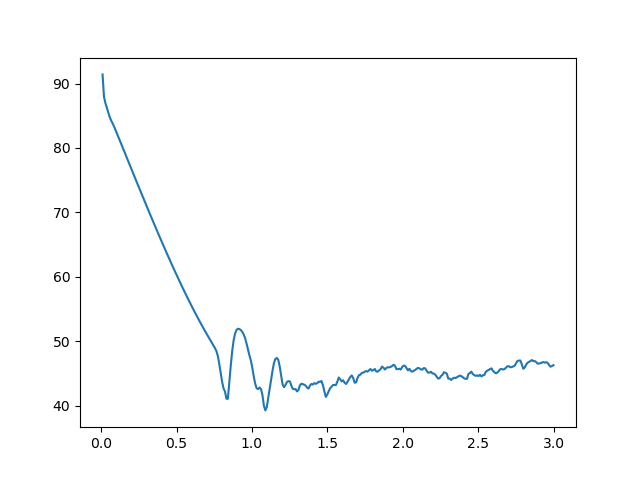

In [254]:
i = 5
theta = np.arctan2(uf[i].v.isel(zC=-1), uf[i].u.isel(zC=-1)) * 180 / np.pi

plt.close()
plt.figure()

plt.plot(uf[i].timeTf, theta);

#### Dissipation rate

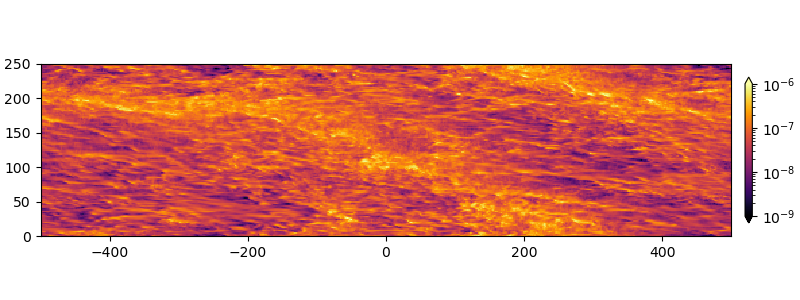

In [11]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)
pmkw = dict(cmap='inferno', norm=mcl.LogNorm(vmin=1e-9, vmax=1e-6))

i = 3
meps = dsf[i].eps.mean('zC')
pm = plt.pcolormesh(dsf[i].xC, dsf[i].yC, meps, **pmkw)
cbar = plt.colorbar(pm, pad=0.02, shrink=0.5, extend='both', location='right')
plt.gca().set_aspect('equal');

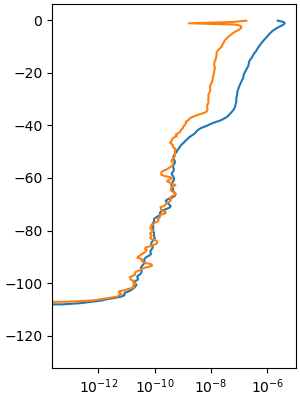

In [19]:
plt.close()
plt.figure(figsize=(3,4), constrained_layout=True)

plt.plot(dsf[i].eps.where(meps>=1e-7).mean(['xC','yC']), dsf[i].zC)
plt.plot(dsf[i].eps.where(meps<1e-8).mean(['xC','yC']), dsf[i].zC)
plt.xscale('log');

In [8]:
def plot_dissipation(ax, ds, **kwargs):
    bkw  = kwargs.pop('bkw')
    pmkw = kwargs.pop('pmkw')
    nf_bld = kwargs.pop('nf_bld')
    sub_str = kwargs.pop('sub_str')
    eps_scale = ds.ustar2**(3/2) / ds.bld
    pm = ax.pcolormesh(ds.timeTf, ds.zC, (ds.TKE_eps.clip(min=1e-16)/eps_scale).T, **pmkw)
    # ax.contour(ds.timeTf, ds.zC, ds.TKE_eps.T, [1e-8], colors='w', linestyles=':')
    # ax.contour(ds.timeTf, ds.zC, ds.TKE_eps.T, [1e-9], colors='w')
    ax.contour(ds.timeTf, ds.zC, ds.b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
    ax.plot(ds.timeTf, -ds.bld, 'xkcd:neon blue')
    ax.plot(ds.timeTf, -ds.mld, 'w')
    if nf_bld is not None:
        ax.plot(ds.timeTf, -nf_bld, c='w', ls=':')
    # ax.plot(ds.timeTf, -ds.hRib, 'xkcd:shamrock', lw=1)
    # ax.plot(ds.timeTf, -ds.bld*ds.hoH, 'xkcd:shamrock', lw=1, ls='--')
    # ax.plot(ds.timeTf, -ds.heps, 'xkcd:canary yellow', lw=0.8)
    # ax.plot(ds.timeTf, -ds.hRib, 'm')
    ax.text(0.03, 0.05, sub_str, fontsize=12, color='w', ha='left', va='bottom', transform=ax.transAxes)
    return pm

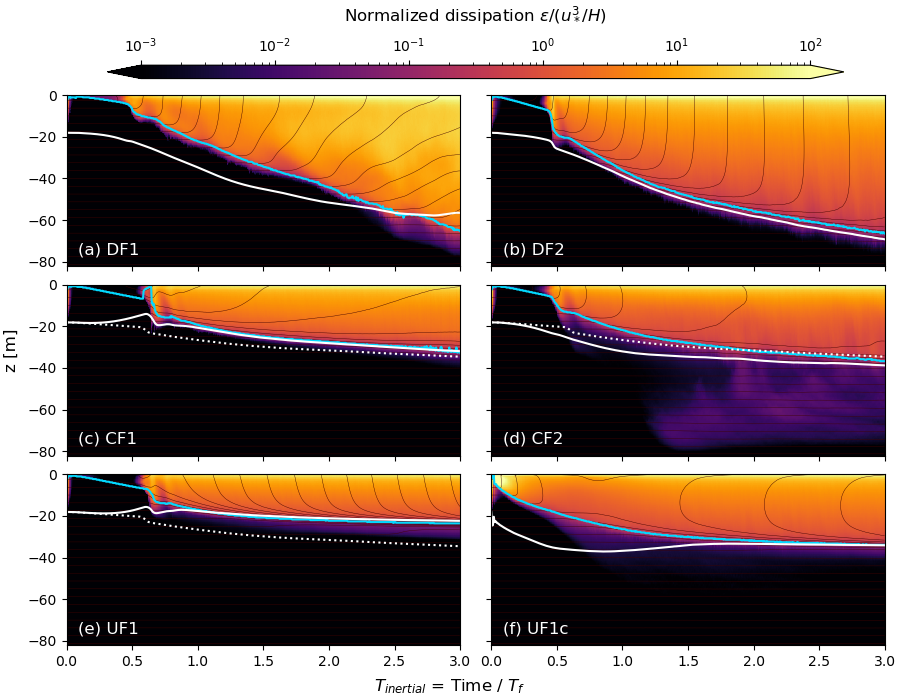

In [12]:
plt.close()
fig,ax = plt.subplots(3,2, figsize=(9,7), constrained_layout=True, sharex=True, sharey=True)

letter = 'abcdef'
cnames = ['DF1', 'DF2', 'CF1', 'CF2', 'UF1', 'UF1c']
bkw = dict(colors='xkcd:deep brown', linewidths=0.3)
pmkw = dict(cmap='inferno', norm=mcl.LogNorm(vmin=1e-3, vmax=1e2))

for i in range(len(ds))[:-1]:#[0, -1, 2, 3, 4, 5]:#
    if i==-1:
        ix, iy = np.unravel_index(1, ax.shape)
    else:
        ix, iy = np.unravel_index(i, ax.shape)
    if i in [2,3,4]:
        nf_bld = uf[-2].mld
    else:
        nf_bld = None
    pm = plot_dissipation(ax[ix,iy], ds[i], bkw=bkw, pmkw=pmkw, nf_bld=nf_bld,
                          sub_str=f'({letter[i]}) {cnames[i]}')

plt.ylim(-82,0)
plt.xlim(0,3)
cbar = fig.colorbar(pm, ax=ax, pad=0.02, shrink=0.9, fraction=0.05, aspect=55, extend='both', location='top')
cbar.set_label(r"Normalized dissipation $\epsilon / (u^3_*/H)$", labelpad=12, fontsize=12)
fig.supylabel('z [m]')
fig.supxlabel(r'$T_{inertial}$ = Time / $T_f$');

plt.savefig('../Figures/Fig3', dpi=600);

#### Turbulent kinetic energy (TKE)

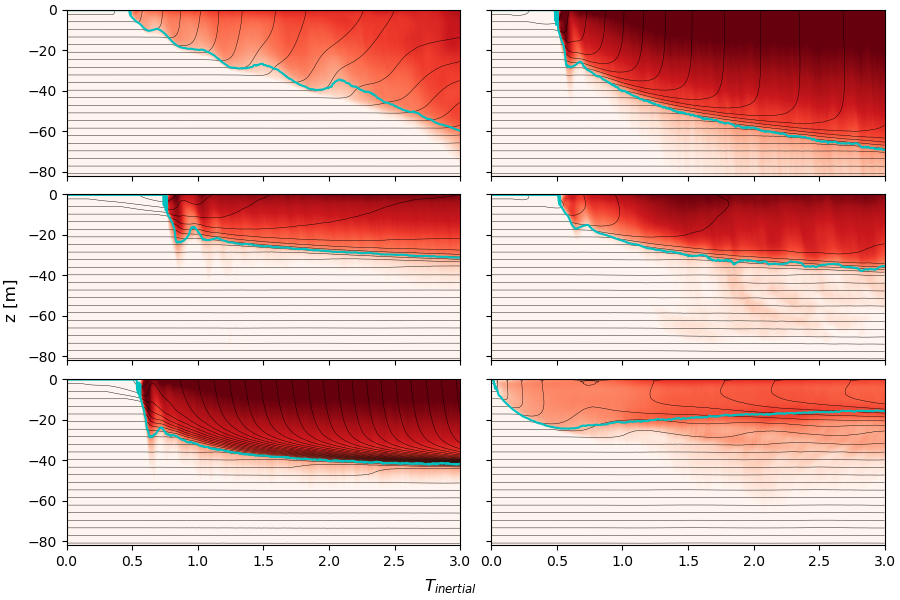

In [8]:
plt.close()
fig,ax = plt.subplots(3,2, figsize=(9,6), constrained_layout=True, sharex=True, sharey=True)

bkw = dict(colors='k', linewidths=0.3)
kw = dict(cmap='Reds', norm=mcl.LogNorm(vmin=1e-5, vmax=1e-3))

ax[0,0].pcolormesh(ds[0].timeTf, ds[0].zC, ds[0].TKE.T, **kw)
# cbar = plt.colorbar(pad=-0.0, extend='both')
ax[0,0].contour(ds[0].timeTf, ds[0].zC, ds[0].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[0,0].plot(ds[0].timeTf, -ds[0].bld, 'c')

ax[0,1].pcolormesh(ds[1].timeTf, ds[1].zC, ds[1].TKE.T, **kw)
ax[0,1].contour(ds[1].timeTf, ds[1].zC, ds[1].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[0,1].plot(ds[1].timeTf, -ds[1].bld, 'c')

ax[1,0].pcolormesh(ds[2].timeTf, ds[2].zC, ds[2].TKE.T, **kw)
ax[1,0].contour(ds[2].timeTf, ds[2].zC, ds[2].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[1,0].plot(ds[2].timeTf, -ds[2].bld, 'c')

ax[1,1].pcolormesh(ds[3].timeTf, ds[3].zC, ds[3].TKE.T, **kw)
ax[1,1].contour(ds[3].timeTf, ds[3].zC, ds[3].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[1,1].plot(ds[3].timeTf, -ds[3].bld, 'c')

ax[2,0].pcolormesh(ds[4].timeTf, ds[4].zC, ds[4].TKE.T, **kw)
ax[2,0].contour(ds[4].timeTf, ds[4].zC, ds[4].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[2,0].plot(ds[4].timeTf, -ds[4].bld, 'c')

ax[2,1].pcolormesh(ds[5].timeTf, ds[5].zC, ds[5].TKE.T, **kw)
ax[2,1].contour(ds[5].timeTf, ds[5].zC, ds[5].b.T, np.arange(0,2.6,0.006)*1e-2, **bkw)
ax[2,1].plot(ds[5].timeTf, -ds[5].bld, 'c')
plt.ylim(-82,0)
plt.xlim(0,3);

fig.supylabel('z [m]')
fig.supxlabel(r'$T_{inertial}$');

#### TKE budget

##### investigate Downfront wind with heating: DF1h

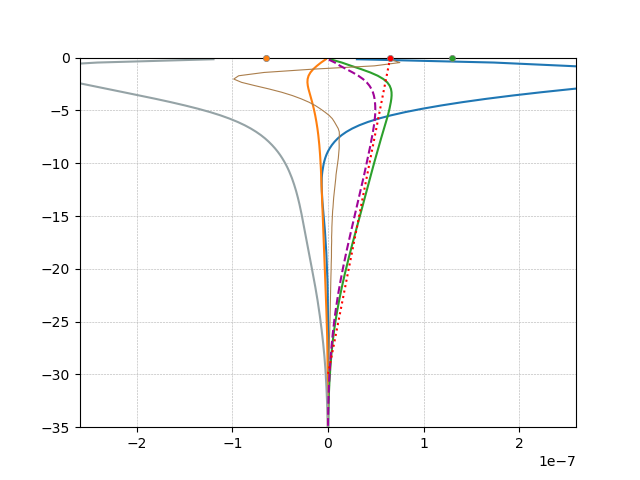

In [185]:
plt.close()
plt.figure()
time_interval = (ds[0].timeTf >= 2) & (ds[0].timeTf < 3)
EBF = ds[0].Qv.where(time_interval).mean('time')*ds[0].attrs['M²']/ds[0].f
B0  = ds[0].Qb.where(time_interval).mean('time')
TBF = EBF + B0

plt.plot(ds[0].ASP.where(time_interval).mean(['time']), ds[0].zC)
plt.plot(ds[0].GSP.where(time_interval).mean(['time']), ds[0].zC, 'C2')
plt.plot(ds[0].wbt.where(time_interval).mean(['time']), ds[0].zC, 'C1')
plt.plot(-(ds[0].TKE_tur + ds[0].TKE_prs + ds[0].TKE_vis).where(time_interval).mean(['time']), ds[0].zC, 'xkcd:tan brown', lw=0.8)
plt.plot(-ds[0].TKE_eps.where(time_interval).mean(['time']), ds[0].zC, 'xkcd:cool grey');
plt.plot((ds[0].GSP + ds[0].wbt).where(time_interval).mean(['time']), ds[0].zC, '--', c='xkcd:barney purple')
plt.scatter(B0,  0, 20, 'C1', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.scatter(EBF, 0, 20, 'C2', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.scatter(TBF, 0, 20, 'r',  marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.plot([TBF, 0], [0, -30], ':r', label='_nolegend_')
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-EBF*2, EBF*2)
plt.ylim(-35, 0);

In [20]:
def plot_tke_budget(ax, ds, sub_str=None, main_ax=True):
    kw = dict(lw=1.5) if main_ax else dict(lw=1)
    time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
    B0  = ds.Qb.where(time_interval).mean('time')
    EBF = ds.Qv.where(time_interval).mean('time')*ds.attrs['M²']/ds.f
    TBF = EBF + B0

    l2, = ax.plot(ds.ASP_ful_sc, ds.sC, **kw)
    l3, = ax.plot(ds.GSP_ful_sc, ds.sC, 'C2', **kw)
    l4, = ax.plot(ds.wb_sc, ds.sC, 'C1', **kw)
    l6, = ax.plot(-(ds.TKE_tur_sc + ds.TKE_prs_sc + ds.TKE_vis_sc), ds.sC, 'xkcd:tan brown', lw=0.8)
    l7, = ax.plot(-ds.TKE_eps_sc, ds.sC, 'xkcd:cool grey', **kw)

    if main_ax:
        l5, = ax.plot(ds.GSP_ful_sc + ds.wb_sc, ds.sC, '--', c='xkcd:barney purple', **kw)
        l1, = ax.plot([TBF, 0], [0, -1], ':r', label='_nolegend_', **kw)
        s1  = ax.scatter(B0,  0, 20, 'C1', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        s2  = ax.scatter(EBF, 0, 20, 'C2', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        s3  = ax.scatter(TBF, 0, 20, 'r',  marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
        ax.text(0.03, 0.05, sub_str, fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
        ax.grid('on', ls='--', lw=0.4)
        if EBF == 0:
            main_xabsm = np.abs(ds.Qu.where(time_interval).mean('time')*ds.attrs['M²']/ds.f)*2
        else:
            main_xabsm = np.abs(EBF)*2
        ax.set_xlim(-main_xabsm, main_xabsm)
        return [l2, l3, l4, l5, l1, l6, l7, s1, s2, s3]
    else:
        xabsm = np.quantile(np.concatenate([ds.ASP_ful_sc, ds.GSP_ful_sc, ds.TKE_eps_sc]), 0.99)
        ax.set_xlim(-xabsm, xabsm)
        ax.set_ylim(-1.2,0)
        # ax.patch.set_alpha(0.6)

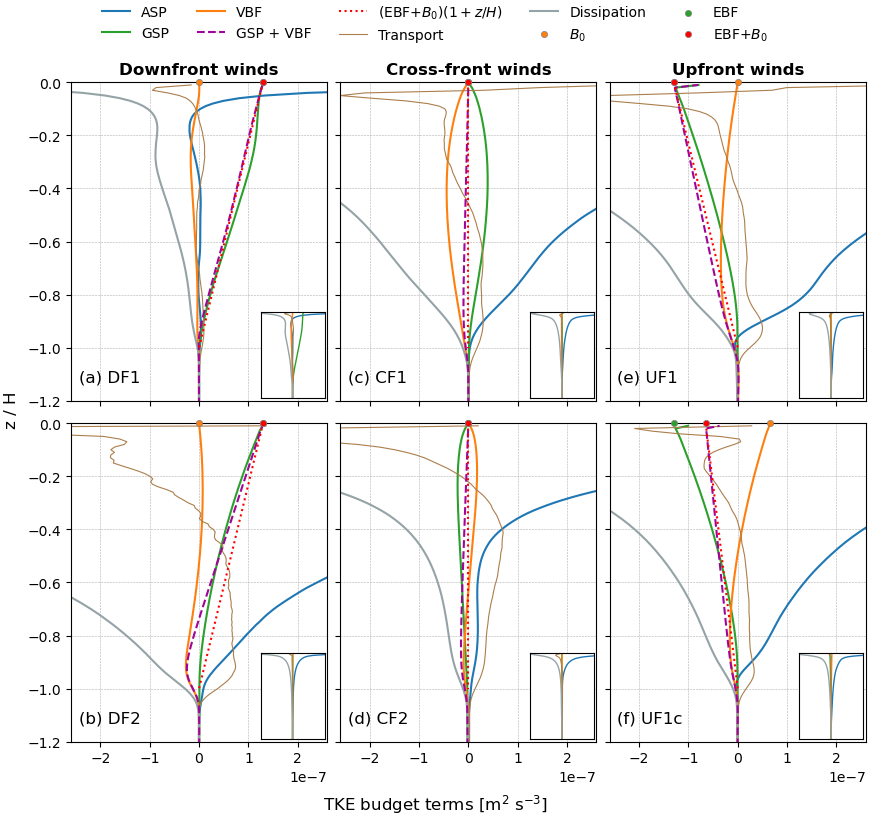

In [31]:
plt.close()
fig,ax = plt.subplots(2,3, figsize=(8.7,8.2), constrained_layout=True, sharey=True, sharex=True)
letters = 'abcdef'
cnames = ['DF1', 'DF2', 'CF1', 'CF2', 'UF1', 'UF1c']

for i in range(len(ds))[:-1]:#[0, -1, 2, 3, 4, 5]:#
    if i==-1:
        ix, iy = np.unravel_index(1, ax.shape, order='F')
    else:
        ix, iy = np.unravel_index(i, ax.shape, order='F')
    handles = plot_tke_budget(ax[ix,iy], ds[i], sub_str=f'({letters[i]}) {cnames[i]}')

    axins = ax[ix,iy].inset_axes([0.74, 0.01, 0.25, 0.27],
                                 xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plot_tke_budget(axins, ds[i], main_ax=False)

ax[0,0].set_title('Downfront winds', fontweight='bold')
ax[0,1].set_title('Cross-front winds', fontweight='bold')
ax[0,2].set_title('Upfront winds', fontweight='bold')
fig.legend(handles, ['ASP', 'GSP', 'VBF', 'GSP + VBF', r'(EBF+$B_0)(1+z/H)$',
                     'Transport', 'Dissipation', r'$B_0$', 'EBF', r'EBF+$B_0$'],
           loc='outside upper center', ncols=5, borderaxespad=-0.1, frameon=False)
plt.ylim(-1.2,0)
fig.supylabel('z / H')
fig.supxlabel(r'TKE budget terms [m$^2$ s$^{-3}$]');

plt.savefig('../Figures/Fig4', dpi=600);

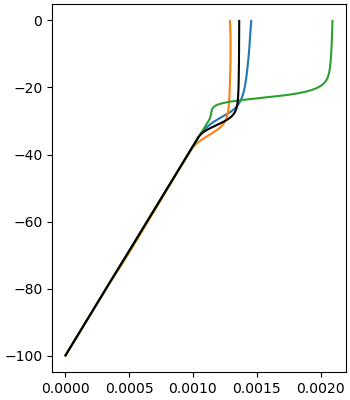

In [66]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 2
time_interval = (ds[i].timeTf >= 2) & (ds[i].timeTf < 3)
plt.plot(ds[i].b.where(time_interval).mean('time'), ds[i].zC)
i = 3
plt.plot(ds[i].b.where(time_interval).mean('time'), ds[i].zC)
i = 4
plt.plot(ds[i].b.where(time_interval).mean('time'), ds[i].zC)

i = -1
plt.plot(ds[i].b.where(time_interval).mean('time'), ds[i].zC, 'k');


#### PV flux

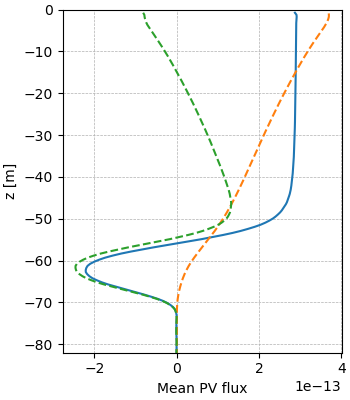

In [5]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 1
time_interval = (ds[i].timeTf >= 2) & (ds[i].timeTf < 3)

plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u.where(time_interval).mean(['time'])[:-1] +
          ds[i].f*ds[i].dwbdz.where(time_interval).mean(['time'])[:-1], ds[i].zC[:-1])
plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u.where(time_interval).mean(['time'])[:-1], ds[i].zC[:-1], '--')
plt.plot( ds[i].f*ds[i].dwbdz.where(time_interval).mean(['time'])[:-1],               ds[i].zC[:-1], '--')
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-82, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');

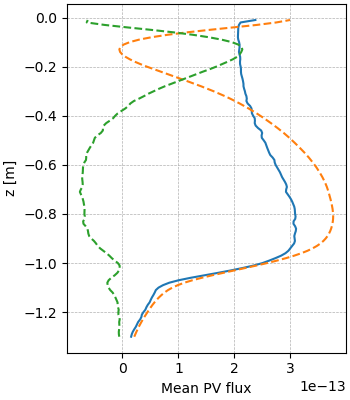

In [242]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 0

plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u_sc + ds[i].f*ds[i].dwbdz_sc, ds[i].sC)
plt.plot(-ds[i].f*ds[i].attrs['M²']*ds[i].u_sc, ds[i].sC, '--')
plt.plot( ds[i].f*ds[i].dwbdz_sc,               ds[i].sC, '--')
plt.grid('on', ls='--', lw=0.5)
# plt.ylim(-82, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');

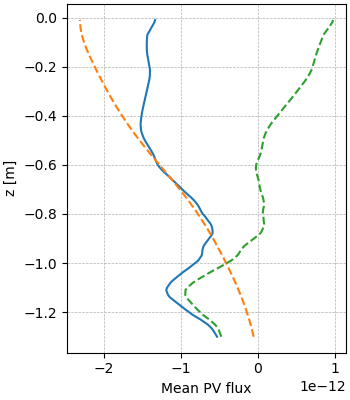

In [243]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)

i = 3

plt.plot(-uf[i].f*uf[i].attrs['M²']*uf[i].u_sc + uf[i].f*uf[i].dwbdz_sc, ds[i].sC)
plt.plot(-uf[i].f*uf[i].attrs['M²']*uf[i].u_sc, ds[i].sC, '--')
plt.plot( uf[i].f*uf[i].dwbdz_sc,               ds[i].sC, '--')
plt.grid('on', ls='--', lw=0.5)
# plt.ylim(-82, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');

#### Reynolds stress

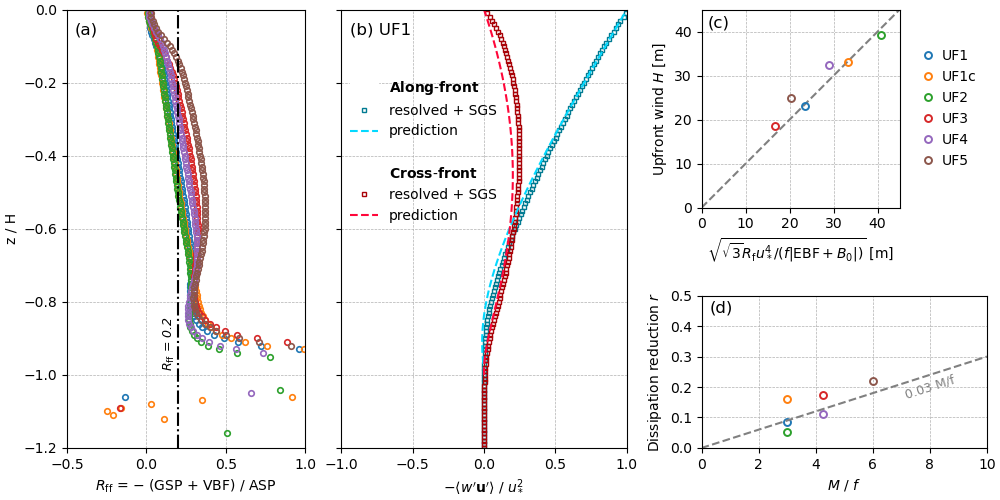

In [39]:
plt.close()
fig = plt.figure(figsize=(10,5), constrained_layout=True)#, sharey=True
time_interval = (uf[0].timeTf >= 2) & (uf[0].timeTf < 3)
xdum = np.array([0,45])
gs = fig.add_gridspec(2, 3, width_ratios=[1,1.2,1.2], height_ratios=[1.3,1])

ax0 = fig.add_subplot(gs[:, 0])
for i in range(len(uf))[:-2]:
    ax0.plot(-(uf[i].wb_sc + uf[i].GSP_ful_sc) / uf[i].ASP_ful_sc, uf[i].sC, 'o', fillstyle='none', ms=4, mew=1.2)
ax0.axvline(0.2, c='k', ls='-.', label='_nolegend_')
ax0.grid('on', ls='--', lw=0.5)
ax0.text(0.03, 0.97, '(a)', fontsize=12, ha='left', va='top', transform=ax0.transAxes)
ax0.text(0.19, -0.99, r'$R_\mathrm{ff}$ = 0.2', fontsize=9, ha='right', va='bottom', color='k', style='italic', rotation=90)
ax0.set_ylim(-1.2, 0)
ax0.set_xlim(-0.5,1)
ax0.set_ylabel('z / H')
ax0.set_xlabel(r'$R_\mathrm{ff}$ = $-$ (GSP + VBF) / ASP');

ax1 = fig.add_subplot(gs[:, 1])
zdum = np.linspace(-1,0)
tau_Derbyshire = (1+zdum)**(3/2 + np.sqrt(3)/2*1j)*(-1j)
i = 0
# p1, = ax1.plot(-(uf[i].wvt_sc/uf[i].ustar2[-1]), uf[i].sC, c='xkcd:ocean')
# p2, = ax1.plot(-(uf[i].wut_sc/uf[i].ustar2[-1]), uf[i].sC, c='xkcd:darkish red')
p3, = ax1.plot(-(uf[i].wv_sc/uf[i].ustar2[-1]), uf[i].sC, 's', c='xkcd:ocean', markersize=3, mfc='none', lw=0.02)
p4, = ax1.plot(-(uf[i].wu_sc/uf[i].ustar2[-1]), uf[i].sC, 's', c='xkcd:darkish red', markersize=3, mfc='none', lw=0.02)
p5, = ax1.plot(-np.imag(tau_Derbyshire), zdum, '--', c='xkcd:neon blue')
p6, = ax1.plot(-np.real(tau_Derbyshire), zdum, '--', c='xkcd:neon red')
p7, = ax1.plot([0], marker='None', linestyle='None')
p8  = plt.Rectangle((0,0), 0, 0, color='w')
ax1.add_patch(p8)
ax1.legend([p8, p3, p5, p7, p8, p4, p6],
           # [p8, p1, p3, p5, p7, p8, p2, p4, p6],
           [r'$\bf{Along}$-$\bf{front}$', 'resolved + SGS', 'prediction', '',
            r'$\bf{Cross}$-$\bf{front}$', 'resolved + SGS', 'prediction'], frameon=False, loc=(0.01, 0.5))
ax1.grid('on', ls='--', lw=0.5)
ax1.text(0.03, 0.97, '(b) UF1', fontsize=12, ha='left', va='top', transform=ax1.transAxes)
ax1.set_ylim(-1.2, 0)
ax1.set_xlim(-1,1)
ax1.set_yticklabels([])
ax1.set_xlabel(r'$-\langle$$w^\prime\bf{u}^\prime$$\rangle$ / $u_*^2$');

ax2 = fig.add_subplot(gs[0, 2])
c = np.sqrt(3)*0.2
ax2.plot(xdum, xdum, c='gray', ls='--', label='_nolegend_')
for i in range(len(uf))[:-2]:
    ax2.plot(np.sqrt(c*uf[i].ustar2**2/uf[i].f/np.abs(uf[i].EBF + uf[i].Qb)).where(time_interval).mean('time'),
                  uf[i].bld.where(time_interval).mean('time'), 'o', fillstyle='none', ms=5, mew=1.4)
ax2.set_aspect('equal', adjustable='box', anchor=(0, 1))
ax2.grid('on', ls='--', lw=0.5)
ax2.text(0.03, 0.97, '(c)', fontsize=12, ha='left', va='top', transform=ax2.transAxes)
ax2.legend(['UF1', 'UF1c', 'UF2', 'UF3', 'UF4', 'UF5'], frameon=False, ncols=1, handletextpad=0,
             loc='right', bbox_to_anchor=(1.45, 0.5))
ax2.set_xlim(xdum)
ax2.set_ylim(xdum)
ax2.set_xticks(np.arange(0,50,10))
ax2.set_yticks(np.arange(0,50,10))
ax2.set_xlabel(r'$\sqrt{\sqrt{3} R_\mathrm{f} u_*^4 / (f|\mathrm{EBF} + B_0|)}$ [m]')
ax2.set_ylabel(r'Upfront wind $H$ [m]');

ax3 = fig.add_subplot(gs[1, 2])
# betas = []
# for i in range(len(uf)):
#     betas.append(uf[i].iASP.where(time_interval).mean('time')/np.sqrt(uf[i].attrs['τ₀']/1026)**3)
# betas = np.array(betas)
# beta1 = betas[6]# np.mean(betas[[0,3,6]])
# beta2 = betas[7]# np.mean(betas[[2,4,5,7]])
for i in [0,3]:
    ax3.plot(np.sqrt(uf[i].attrs['M²'])/uf[i].f, 
             1-uf[i].iEPS.where(time_interval).mean('time') / uf[6].iEPS.where(time_interval).mean('time'), 'o', color=f'C{i}', fillstyle='none', ms=5, mew=1.4)#beta1/np.sqrt(uf[i].attrs['τ₀']/1026)**3
ax3.plot(np.sqrt(uf[1].attrs['M²'])/uf[1].f, 1 - uf[1].iEPS.where(time_interval).mean('time') / (uf[6].iEPS.where(time_interval).mean('time') +\
                                                                                                 0.4*(uf[1].Qb*uf[1].bld).where(time_interval).mean('time')),
           'o', color=f'C{1}', fillstyle='none', ms=5, mew=1.4)
for i in [2,4,5]:
    ax3.plot(np.sqrt(uf[i].attrs['M²'])/uf[i].f, 
             1 - uf[i].iEPS.where(time_interval).mean('time') / uf[7].iEPS.where(time_interval).mean('time'), 'o', color=f'C{i}', fillstyle='none', ms=5, mew=1.4)
ax3.plot([0,10], [0,10*0.03], c='gray', ls='--', label='_nolegend_')
ax3.grid('on', ls='--', lw=0.5)
ax3.text(0.03, 0.97, '(d)', fontsize=12, ha='left', va='top', transform=ax3.transAxes)
ax3.text(8, 0.2, '0.03 M/f', c='gray', fontsize=9, rotation=np.arctan(0.03)/np.pi*180, rotation_mode='anchor',
         transform_rotates_text=True, va='center', ha='center')
ax3.set_xlim(0,10)
ax3.set_ylim(0,0.5)
ax3.set_xlabel(r'$M$ / $f$')
ax3.set_ylabel(r'Dissipation reduction $r$');

plt.savefig('../Figures/Fig5', dpi=600);

In [186]:
betas

array([8.01349235, 7.61099165, 9.80104071, 7.73932652, 9.75670616,
       9.36723101, 7.96046364, 9.55045264])

#### Scaling of vertically integrated GSP

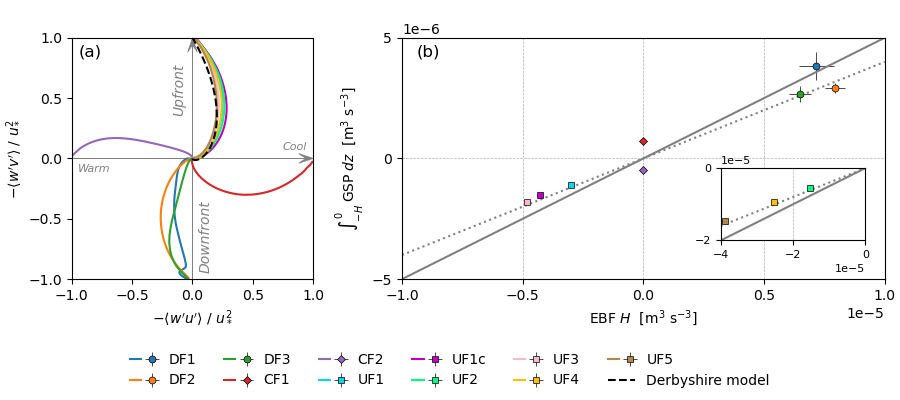

In [56]:
plt.close()
fig,ax = plt.subplots(1,2, figsize=(9,4), width_ratios=[1,2], constrained_layout=True)
zdum = np.linspace(-1,0)
tau_Derbyshire = (1+zdum)**(3/2 + np.sqrt(3)/2*1j)*(-1j)
time_interval = (ds[0].timeTf >= 2) & (ds[0].timeTf < 3)
xdum = np.array([-1e-5, 1e-5])
uf_colors = ['xkcd:aqua blue', 'm', 'xkcd:minty green', 'xkcd:baby pink', 'xkcd:marigold', 'xkcd:dark tan']

line_hanldes = []
for i in [0, 1, -1]:
    l, = ax[0].plot(-(ds[i].wu_sc/ds[i].ustar2[-1]), -(ds[i].wv_sc/ds[i].ustar2[-1]))
    line_hanldes.append(l)
for i in [2, 3]:
    l, = ax[0].plot(-(ds[i].wu_sc/ds[i].ustar2[-1]), -(ds[i].wv_sc/ds[i].ustar2[-1]))
    line_hanldes.append(l)
for i in range(len(uf))[:-2]:
    l, = ax[0].plot(-(uf[i].wu_sc/uf[i].ustar2[-1]), -(uf[i].wv_sc/uf[i].ustar2[-1]), c=uf_colors[i])
    line_hanldes.append(l)
# ax[0].plot(-(ds[-1].wu_sc/ds[-1].ustar2[-1]), -(ds[-1].wv_sc/ds[-1].ustar2[-1]), '--g')
lD, = ax[0].plot(-np.real(tau_Derbyshire), -np.imag(tau_Derbyshire), '--k')
arrowx = FancyArrow(-1, 0, 2, 0, width=1e-4, lw=0.5, head_width=0.08, color='gray', overhang=0.5, clip_on=False, length_includes_head=True, label='_nolgend_')
arrowy = FancyArrow(0, -1, 0, 2, width=1e-4, lw=0.5, head_width=0.08, color='gray', overhang=0.5, clip_on=False, length_includes_head=True, label='_nolgend_')
ax[0].add_patch(arrowx)
ax[0].add_patch(arrowy)
ax[0].set_aspect('equal', adjustable='box', anchor=(0.5, 0.65))
ax[0].text(0.03, 0.97, '(a)', fontsize=12, ha='left', va='top', transform=ax[0].transAxes)
ax[0].text(-0.05, 0.35, 'Upfront', fontsize=10, ha='right', va='bottom', color='gray', style='italic', rotation=90)
ax[0].text(0.05, -0.35, 'Downfront', fontsize=10, ha='left', va='top', color='gray', style='italic', rotation=90)
ax[0].text(-0.95, -0.05, 'Warm', fontsize=8, ha='left', va='top', color='gray', style='italic')
ax[0].text(0.95, 0.05, 'Cool', fontsize=8, ha='right', va='bottom', color='gray', style='italic')
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_xticks(np.arange(-1,1.5,0.5))
ax[0].set_yticks(np.arange(-1,1.5,0.5))
ax[0].set_xlabel(r'$-\langle$$w^\prime u^\prime$$\rangle$ / $u_*^2$')
ax[0].set_ylabel(r'$-\langle$$w^\prime v^\prime$$\rangle$ / $u_*^2$');

scat_hanldes = []
for i in [0, 1, -1]:
    # ax[1].scatter((ds[i].EBF*ds[i].bld).where(time_interval).mean('time'), ds[i].iGSP.where(time_interval).mean('time'), 20)
    s = ax[1].errorbar((ds[i].EBF*ds[i].bld).where(time_interval).mean('time'), ds[i].iGSP_ful.where(time_interval).mean('time'),
                   xerr=(ds[i].EBF*ds[i].bld).where(time_interval).std('time'), yerr=ds[i].iGSP_ful.where(time_interval).std('time'),
                   fmt='o', ms=5, elinewidth=0.5, ecolor='k', mec='k', mew=0.5)
    scat_hanldes.append(s)
for i in [2, 3]:
    s = ax[1].errorbar((ds[i].EBF*ds[i].bld).where(time_interval).mean('time'), ds[i].iGSP_ful.where(time_interval).mean('time'),
                   xerr=(ds[i].EBF*ds[i].bld).where(time_interval).std('time'), yerr=ds[i].iGSP_ful.where(time_interval).std('time'),
                   fmt='D', ms=4, elinewidth=0.5, ecolor='k', mec='k', mew=0.5)
    scat_hanldes.append(s)
for i in [0, 1, 3]:
    s = ax[1].errorbar((uf[i].EBF*uf[i].bld).where(time_interval).mean('time'), uf[i].iGSP_ful.where(time_interval).mean('time'),
                   xerr=(uf[i].EBF*uf[i].bld).where(time_interval).std('time'), yerr=uf[i].iGSP_ful.where(time_interval).std('time'),
                   fmt='s', ms=4, elinewidth=0.5, c=uf_colors[i], ecolor='k', mec='k', mew=0.5)
    scat_hanldes.append(s)
ax[1].plot(xdum, xdum*0.5, c='gray')
ax[1].plot(xdum, xdum*0.4, ls=':', c='gray')
ax[1].text(0.03, 0.97, '(b)', fontsize=12, ha='left', va='top', transform=ax[1].transAxes)
ax[1].set_xlim(xdum)
ax[1].set_ylim(xdum*0.5)
ax[1].set_xticks(np.arange(-1e-5,1.5e-5,0.5e-5))
ax[1].set_yticks(np.arange(-0.5e-5,1e-5,0.5e-5))
ax[1].grid('on', ls='--', lw=0.5)
ax[1].set_aspect('equal', adjustable='box', anchor=(0.5, 0.65))
ax[1].set_ylabel(r'$\int_{-H}^0 \;\mathrm{GSP}\; dz$  [m$^3$ s$^{-3}$]')
ax[1].set_xlabel(r'EBF $H$  [m$^3$ s$^{-3}$]');

axins = ax[1].inset_axes([0.66, 0.16, 0.3, 0.3])
for i in [2, 4, 5]:
    s = axins.errorbar((uf[i].EBF*uf[i].bld).where(time_interval).mean('time'), uf[i].iGSP_ful.where(time_interval).mean('time'),
                   xerr=(uf[i].EBF*uf[i].bld).where(time_interval).std('time'), yerr=uf[i].iGSP_ful.where(time_interval).std('time'),
                   fmt='s', ms=4, elinewidth=0.5, c=uf_colors[i], ecolor='k', mec='k', mew=0.5)
    scat_hanldes.append(s)
scat_hanldes[-4], scat_hanldes[-3] = scat_hanldes[-3], scat_hanldes[-4] # swap order so scat_hanldes is consistent with line_hanldes
xdum = np.array([-4e-5, 0e-5])
axins.plot(xdum, xdum*0.5, c='gray')
axins.plot(xdum, xdum*0.4, ls=':', c='gray')
axins.set_xlim(xdum)
axins.set_ylim(xdum*0.5)
axins.set_xticks(np.arange(-4e-5,2e-5,2e-5))
axins.set_yticks(np.arange(-2e-5,2e-5,2e-5))
axins.grid('on', ls='--', lw=0.5)
axins.tick_params(axis='both', which='major', labelsize=8)
axins.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
tx = axins.xaxis.get_offset_text()
tx.set_fontsize(8)
tx = axins.yaxis.get_offset_text()
tx.set_fontsize(8)
axins.set_aspect('equal', adjustable='box')

fig.legend([(i,j) for i,j in zip(line_hanldes, scat_hanldes)] + [lD],
           ['DF1', 'DF2', 'DF3', 'CF1', 'CF2',
            'UF1', 'UF1c', 'UF2', 'UF3', 'UF4', 'UF5', 'Derbyshire model'], ncols=6,
             frameon=False, loc='outside lower center', handler_map={tuple: HandlerTuple(ndivide=None)});

plt.savefig('../Figures/Fig6', dpi=600);

In [62]:
ds[3].iGSP_ful.where(time_interval).mean('time')/(ds[4].EBF*ds[3].bld).where(time_interval).mean('time')

<xarray.DataArray ()> Size: 8B
array(0.10547455)

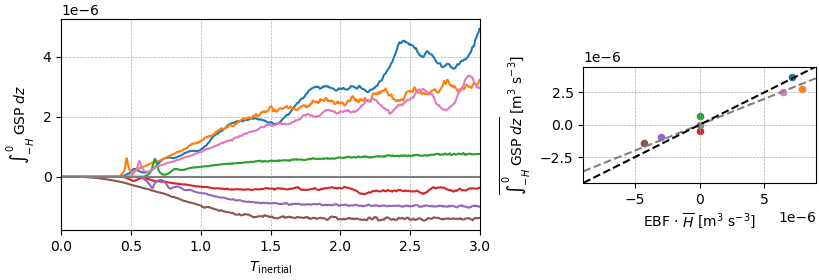

In [109]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(8.2,2.8), width_ratios=[1.8,1], constrained_layout=True)
time_interval = (ds[0].timeTf >= 2) & (ds[0].timeTf < 3)
xdum = np.array([-.9e-5, .9e-5])

for i in range(len(ds)):
    ax[0].plot(ds[i].timeTf, ds[i].iGSP)#/ds[i].bld

ax[0].grid('on', ls='--', lw=0.5)
ax[0].set_xlim(0,3)
ax[0].set_ylabel(r'$\int_{-H}^0 \;\mathrm{GSP}\; dz$') #\frac{1}{H}
ax[0].set_xlabel(r'$T_{\mathrm{inertial}}$');

for i in range(len(ds)):
    ax[1].scatter((ds[i].EBF*ds[i].bld).where(time_interval).mean('time'), ds[i].iGSP.where(time_interval).mean('time'), 20)#
ax[1].plot(xdum, xdum*0.4, ls='--', c='gray')
ax[1].plot(xdum, xdum*0.5, ls='--', c='k')
ax[1].set_xlim(xdum)
ax[1].set_ylim(xdum/2)
ax[1].grid('on', ls='--', lw=0.5)
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_ylabel(r'$\overline{\int_{-H}^0 \;\mathrm{GSP}\; dz}$ [m$^3$ s$^{-3}$]')
ax[1].set_xlabel(r'EBF $\cdot$ $\overline{H}$ [m$^3$ s$^{-3}$]');